In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
pd.set_option('display.max_columns', None)
from shapely.geometry import Point
import seaborn as sns
import fiona
import math #Hi testing
import plotly.express as px
from thefuzz import fuzz
from thefuzz import process
import random
from sklearn.linear_model import LassoCV
import statsmodels.api as sm

In [35]:
#Read in the data and keep only US Continental States and DC
stores_general = pd.read_csv('/srv/data/my_shared_data_folder/rafi/2022_Business_Academic_QCQ_grocery.csv')
stores_general.drop(['Unnamed: 0'],inplace=True,axis=1)
territories = ['PR', 'FM', 'MP', 'GU', 'VI', 'MH','AK','HI']
stores_general = stores_general.drop(stores_general[stores_general['STATE'].isin(territories)].index)

In [36]:
#Create lists of Supermarkets/Companies owned by the Parent Coporations of Interest (Supermarkets/Companies were taken from Wikipedia)

#Ahold Delhaize owned supermarkets/companies
ahold = ["Bottom Dollar Food",
    "Food Lion",
    "FreshDirect",
    "Giant",
    "Giant Food",
    "Hannaford",
    "Stop & Shop",
    "Peapod",
    "Bfresh",
    "Eastside Marketplace",]

#WALMART owned supermarkets/companies
walmart = ["WALMART","SAM'S CLUB"]

#Krogers owned supermarkets/companies
kroger = ["Baker's",
    "City Market",
    "Dillons",
    "Food 4 Less",
    "Foods Co.",
    "Fred Meyer",
    "Fry's",
    "Gerbes",
    "Harris Teeter",
    "JayC",
    "King Soopers",
    "Kroger",
    "Mariano's",
    "Metro Market",
    "Pay Less",
    "Pick 'n Save",
    "QFC",
    "Ralphs",
    "Ruler Foods",
    "Smith's",]

# Albertsons owned supermarkets/companies
albertsons= ["Acme Markets",
    "Albertsons",
    "Albertsons Market",
    "Amigos",
    "Andronico's",
    "Balducci's",
    "Carrs",
    "Haggen",
    "Jewel-Osco",
    "Kings Food Markets",
    "Lucky",
    "Market Street",
    "Pak 'n Save",
    "Pavilions",
    "Randalls",
    "Safewa",
    "Shaw's",
    "Star Market",
    "Tom Thumb",
    "United Supermarkets",
    "Vons",
    "Buttrey Food and Drug",
    "Max Food and Drug",
    "Max Foods",
    "Skagg's Albertsons",
    "Super Saver",]

#Costco owned supermarkets/companies
costco = ["Costco"]

In [37]:
#Apply a string match through thefuzz that compares all stores to the parent corporations owned stores
#We decided to use a threshold of 77
#Generates a list of potential unique string matches
#The matches list's length is based on the number of different stores the parent corporation owns
#parent was initialized for each parent coporation (finished at costco)
'''
parent = costco
companies = stores_general["COMPANY"]

matches = []
for item in parent:
    for result in process.extract(item, companies, limit=len(parent)+1):
        store = result[0]
        score = result[1]
        if score >= 77 and store not in matches:
            matches.append(store)

print(matches)

# i.e. returns: ['COSTCO DELI']
'''

'\nparent = costco\ncompanies = stores_general["COMPANY"]\n\nmatches = []\nfor item in parent:\n    for result in process.extract(item, companies, limit=len(parent)+1):\n        store = result[0]\n        score = result[1]\n        if score >= 77 and store not in matches:\n            matches.append(store)\n\nprint(matches)\n\n# i.e. returns: [\'COSTCO DELI\']\n'

In [38]:
#Generated String Matches from above

#String matched brands owned by Walmart:
walmart_string = ['WALMART GROCERY PICKUP', 'WALMART GROCERY PKUP-DELIVERY', "SAM'S CLUB DELI"]
#Doesn't appear to have Walmart Neighborhood Stores

#String matched brands owned by Ahold Delhaize:
ahold_string = ['BOTTOM DOLLAR', 'DOLLAR DOLLAR', 'FOOD', 'FOOD 4 LESS', 'FOOD LION', 'FRESH DIRECT', 'REC', 'FRESH', 'H & H', 'S & S', 'FRESHII', 'GIANT', 'GIANT EAGLE', 'GIANT EAGLE FLORAL', 'GIANT FOOD', 'HANNAFORD', 'STOP & SHOP', 'PEA POD', 'BFRESH MARKET', 'REFRESH', 'EASTSIDE MARKETPLACE', 'WESTSIDE MARKETPLACE', 'MARKET', 'E MARKET', 'MARKETPLACE']

#String matched brands owned by Kroger:
kroger_string = ["BAKER'S", 'S & S', 'BAKERS', "BAKER'S GAS & WELD SUPLS INC", "BAKER'S GAS", "BAKER'S MARKET", "BAKER'S PRO FARM LLC", 'BAKER STREET MARKET', "BAKER'S KWIK SHOP", 'CITY MARKET', 'DILLONS', 'FOOD 4 LESS', 'FOODS CO', 'FRED MEYER', "FRY'S FOOD", 'GERBES SUPER MARKET', 'GERBES SUPER MARKETS', 'GE', 'GERBES SUPERMARKET', 'HARRIS TEETER', 'JAYC', "JAYCEE'S", 'JAYCON', 'CITY-RALEIGH-JAYCEE PARK-CMNTY', 'JAYCE MINIMARKET', 'NAY & JAY', 'KING SOOPERS', 'KROGER', "MARIANO'S", 'METRO MARKET', 'METRO MINI MARKET', 'MARKET MARKET', 'PAY LESS LIQUORS', 'PAY LESS SUPER MARKETS', 'PAY LESS GAS & FOOD', 'PAY LESS IGA', 'FOOD FOR LESS', 'FAR LESS FOOD MARKET', 'MORE FOR LESS', 'PRICE LESS FOODS', 'COST LESS FOODS CO', "PICK'N SAVE", 'QFC', 'RALPHS', 'RULER FOODS', "SMITH'S"]

#String matched brands owned by Costco
costco_string = ["COSTCO DELI"]

#String matched brands owned by Albertsons
albertsons_string = ['ACME MARKETS', 'ALBERTSONS', 'ALBERTSONS MARKET', 'MARKET MARKET', 'MARKET', '2 AMIGOS', 'AMIGO', 'LOS AMIGOS DISTRIBUTING', 'DOS AMIGOS MARKET', '3 AMIGOS BEER WINE-FOOD STORE', 'THREE AMIGOS', 'AMIGOS FOOD MART', 'LOS AMIGOS', 'AMIGOS MKT LOS', 'AMIGOS MARKET 7', 'TIENDA LOS AMIGOS', 'AMIGOS CONVENIENCE STORE', 'LOS AMIGOS UNO', 'AMIGOS LATIN GROCERY', 'AMIGOS UNITED', 'AMIGOS FOOD MART LLC', 'LOS AMIGOS MARKET', 'LOS AMIGOS SUPERMARKET', 'ICO', "ANDRONICO'S COMMUNITY MARKETS", "KRAUSZER'S FOOD STORE", "CASEY'S", "MR T'S", "SEVEN'S", "PATTY'S PANTRY & DELI", "CASHION'S QUIK STOP", 'E C F S SNACKS LLC', "MICKEY'S T-MART INC", "STATLER'S COUNTRY MART", "MIKE'S CONVENIENCE", "BELL'S ROWLESBURG GROCERY", "SOCCORSI'S GROCERY & SUBS", 'CC', "BALDUCCI'S FOOD LOVER'S MARKET", "DANIEL'S MARKET", "GRILLO'S MARKET", 'S & G CONVENIENCE MART', "NANCY'S FOODMART", "MILLER'S MARKETS", "MAYNARD'S OF FLANDREAU", "SKIP'S", "HARDESTY'S EXPRESS MART LLC", "KASSAR'S FOOD & GIFTS", "JERRY'S MARKET & LIQUOR", "SHELLY'S GROCERY & BAKERY LLC", 'CARRS/SAFEWAY', 'CARRS SAFEWAY', 'CARRS QUALITY CTR PALMER SHPG', 'BIG CHEAP CASH & CARR', 'C & B USED CARS', 'HAGGEN', 'HAGGEN FOOD & PHARMACY', 'HAGGEN SUPPORT CTR', 'HAGGEN FOOD', 'GE', 'JEWEL-OSCO', 'KINGS FOOD MARKETS', 'KINGS FOOD MARKET', "KING'S FOOD MARKET", "KING'S FOODMARKET", 'KINGS FOOD MART', 'FOOD', 'LUCKY', 'LUCKY 3', 'LUCKY 7', "LUCKY'S", 'LUCKY 8', 'LUCKYS', 'LUCKY SEVEN FOOD STORE', 'LUCKY FOOD FARMERS MARKET', 'LUCKY GROCERY & DELI', 'LUCKY DOLLAR', 'LUCKY CHARM CONVENIENCE STORE', 'LUCKY STAR MARKET LLC', 'LUCKY FOOD MART LLC', 'LUCKY MARKET', "LUCKY'S STATION", 'LUCKY MARKET LLC', "LUCKY'S SUPER MARKET", 'MARKET STREET', "PAK 'N SAVE", 'U-SAVE FOOD STORE', 'GOLD LINE GRAB N GO', 'INDO PAK SUPERMARKET', 'STOP N GO FOOD MART', 'STOP N GO ENTERPRISES INC', "OCALA SHOP N' PLAY LLC", 'J & N MINI MART 2', "GRAB 'N GO MART LLC", 'KWIK PAK FOOD MART', "SHOP 'N SAVE EXPRESS", 'PIC-N-SAVE MARKET', 'U-SAVE TRAVEL PLAZA', "UP NORT' SWEET N SAVORY", 'STOP N SHOP WESTFIELD', "SACK 'N SAVE FOOD", "STOP 'N GO MARKETS OF TEXAS", 'CARTA N SHORE GARAGE', 'MASALA INDO PAK GROCERS', 'IN N OUT FOOD & GAS LLC', "GAS 'N' GO FOOD & BEVERAGE", 'N A M C COMMUNITY MARKET INC', 'PAVILIONS', 'RANDALLS', 'SAFEWAY', 'S & S', "SHAW'S SUPERMARKET", "SHAW'S SUPERMARKETS INC", 'STAR MARKET', 'TOM THUMB', 'UNITED SUPERMARKETS', 'VONS', 'FOOD 4 LESS', 'FOOD MART', 'FOOD LION', 'HERA FOOD MART', 'FOOD TOWN', 'FOOD FAIR', 'OHM FOOD MART', "D'S FOOD STORE", 'FOOD EXPRESS', 'E Z FOOD MART', 'JR FOOD MART', 'EXPRESS FOOD', 'MR FOOD MART', 'CITGO CONVENIENT FOOD MART', 'GREEN ACRES HEALTH FOOD STORE', 'FRIENDSHIP FOOD STORES INC', 'VERISTAS AFRICAN FOOD STORE', 'ILLINOIS VALLEY FOOD & DELI', "FRY'S FOOD", 'FOOD CITY', 'MAX FOODS', 'MAXI FOODS', 'FOODS', 'FOOD MAX', 'SUPER ONE FOODS', 'SUNSHINE FOODS', 'JAMBOREE FOODS', 'DAY STAR FOODS', "SULLIVAN'S FOODS", 'AFFILIATED FOODS CO-OP', "JENSEN'S FINEST FOODS", 'EAST DAKOTAH NATURAL FOODS', "JENSEN'S FOODS", 'RITE PRICE FOODS', 'VALLEY CENTER FOODS', 'SUPER SAVER', 'SUPER SAVE', 'SUPER SAVER INC', 'SUPER', 'SUPER SAVER COST PLUS', "SAAR'S SUPER SAVER FOODS"]

In [39]:
#Cleaned lists from the string matches of supermarkets/companies actually owned by the parent coprporation
#***NOTE***There will be a margin of error from this process because stores were validated through manual checks
#***NOTE***It was unrealistic to manually inspect every store generated this way so there will be supermarkets/companies that do not actually belong to the parent coporation
#***NOTE***STOP AND SHOP SUPERMARKET was missing from string match so it was manually added
#KROGERS FINAL
kroger_clean = ["BAKER'S",
 'BAKERS', 
 'CITY MARKET',
 'DILLONS',
 'FOOD 4 LESS', 
 'FOODS CO', 
 'FRED MEYER', 
 "FRY'S FOOD",
 'GERBES SUPER MARKET',  
 'GERBES SUPER MARKETS', 
 'GERBES SUPERMARKET', 
 'HARRIS TEETER', 
 'JAYC', 
 'KING SOOPERS',
 'KROGER',
 "MARIANO'S",
 'METRO MARKET', 
 'PAY LESS SUPER MARKETS',
 "PICK'N SAVE", 
 'QFC', 
 'RALPHS', 
 'RULER FOODS', 
 "SMITH'S","KROGER PICK UP"]

#Ahold Delhaize FINAL:
ahold_clean = [ 'FOOD LION',
 'GIANT',
 'GIANT EAGLE',
 'GIANT FOOD',
 'HANNAFORD',
 'STOP & SHOP',
 'BFRESH MARKET',
 'EASTSIDE MARKETPLACE','STOP & SHOP SUPERMARKET']

#WALMART FINAL:
walmart_clean = ['WALMART GROCERY PICKUP',
 'WALMART GROCERY PKUP-DELIVERY', 
 "SAM'S CLUB DELI"]

#COSTCO FINAL:
costco_clean = ["COSTCO DELI"]

#ALBERTSONS FINAL:
albertsons_clean = ['ACME MARKETS',
'ALBERTSONS',
'ALBERTSONS MARKET',
'AMIGOS UNITED',
"ANDRONICO'S COMMUNITY MARKETS",
'CARRS/SAFEWAY',
'CARRS SAFEWAY',
'HAGGEN',
'HAGGEN FOOD & PHARMACY',
'HAGGEN FOOD',
'JEWEL-OSCO',
'KINGS FOOD MARKETS',
'KINGS FOOD MARKET',
'MARKET STREET',
"PAK 'N SAVE",
'PAVILIONS',
'RANDALLS',
'SAFEWAY',
'STAR MARKET',
'TOM THUMB',
'UNITED SUPERMARKETS',
'VONS',
'SUPER SAVER',
'CARRS QUALITY CTR PALMER SHPG',
 "SAAR'S SUPER SAVER FOODS"]

In [40]:
#Records the removed values from the string matching for each store
#"Removed" list can be used to see the values we chose to remove from the string match
kroger_removed = [value for value in kroger_string if value not in kroger_clean]
ahold_removed = [value for value in ahold_string if value not in ahold_clean]
walmart_removed = [value for value in walmart_string if value not in walmart_clean]
costco_removed = [value for value in costco_string if value not in costco_clean]
albertsons_removed = [value for value in albertsons_string if value not in albertsons_string]

In [41]:
def parent_name(row):
    '''Creates a new column called "PARENT NAME" based on the cleaned string match list''' 
    '''The new column generalizes individual companies into their parent coporation (ie. Walmart, Krogers, etc.)''' 
    companies = row['COMPANY']  
    
    if companies in walmart_clean:
        return 'WALMART'
    if companies in costco_clean:
        return 'COSTCO'
    if companies in ahold_clean:
        return 'AHOLD DELHAIZE'
    if companies in kroger_clean:
        return 'KROGER'
    if companies in albertsons_clean:
        return 'ALBERTSONS'
    else:
        return 'OTHER'

stores_general['STORE TYPE'] = stores_general.apply(parent_name, axis=1)

In [42]:
#Locate the unique primary sic codes present within the supermarkets/companies owned by the parent corporations of interest
#These unique primary SIC codes will be used as the basis of how we filter the main dataset to include only relevant supermarkets/companies (ie. removing convenient stores)

#Step 1: Filter a dataframe based on parent coporations
parent_companies = ['WALMART', 'COSTCO', 'KROGER', 'AHOLD DELHAIZE','ALBERTSONS']
filtered_df = stores_general[stores_general['STORE TYPE'].isin(parent_companies)]

# Step 2: Extract the PRIMARY SIC CODES values
primary_sic_codes = filtered_df['PRIMARY SIC CODE']

# Step 3: Get the unique PRIMARY SIC CODES values
unique_sic_codes = primary_sic_codes.unique()

# Print the unique PRIMARY SIC CODES
unique_sic_codes = np.delete(unique_sic_codes,(np.where(unique_sic_codes == 541103)))

#***NOTE remove SIC Code 541103 since it contains the SIC code for convenient stores

In [43]:
def sic_filter(df):
    """
    Filters the dataframe to keep only the stores with specific primary SIC codes,
    including NaN values. SIC codes are from the parent corporation's subsidiary's Primary SIC codes

    The function takes in an unfiltered dataframe as a parameter.
    The function returns a filtered dataframe.
    """
    sic_codes = unique_sic_codes
    filtered_df = df[df['PRIMARY SIC CODE'].isin(sic_codes) | df['PRIMARY SIC CODE'].isna()]
    return filtered_df

supermarkets = sic_filter(stores_general)

In [44]:
def update_parent_name(df):
    """
    Helps account for erros in manual string matching selection
    Checked for different Parent Numbers within each Parent Group and if the company had a different Parent Number 
    than the accepted, the company was grouped to other
    """
    accepted_parent_numbers = {
        238136725.0: "AHOLD DELHAIZE",
        5995907.0: "ALBERTSONS",
        7521503.0: "KROGER",
        5889993.0: "WALMART",
        441311800.0: "COSTCO"
    }
    
    for parent_number, parent_name in accepted_parent_numbers.items():
        df.loc[(df["PARENT NUMBER"] != parent_number) & (df["STORE TYPE"] == parent_name), "STORE TYPE"] = "OTHER"
    
    return df
supermarkets = update_parent_name(supermarkets)
#Assigns Parent Number of Albertsons to CARRS
supermarkets.loc[supermarkets[supermarkets["COMPANY"] == "CARRS QUALITY CTR PALMER SHPG"].index, "PARENT NUMBER"] = 5995907.0

In [45]:
def process_dataframe(df):
    """
    Process the dataframe by generating parent numbers for companies.
    Generates a random parent number from 0-9999 if the original parent number was NaN.
    If the same company appears with a parent number of NaN, it doesn't get a new parent number; it gets the same parent number as its counterpart.
    LIMITATIONS: This function does not account for when two different corporations have companies with the same name;
    it will ultimately group companies with the same name into one parent number even if they are actually different organizations.
    This type of anomaly is infrequent, so we will overlook this issue.
    """

    companies = {}

    def process_row(row):
        company = row["COMPANY"]
        parent_number = row["PARENT NUMBER"]

        if pd.isna(parent_number):
            if company in companies:
                existing_parent = companies[company]
                if not pd.isna(existing_parent):
                    row["PARENT NUMBER"] = existing_parent
            else:
                new_parent_number = random.randrange(0, 9999)
                companies[company] = new_parent_number
                row["PARENT NUMBER"] = new_parent_number
        else:
            companies[company] = parent_number

        return row

    df_na = df.loc[df["PARENT NUMBER"].isna()] 
    company_list = df_na["COMPANY"].unique().tolist()
    df = df.apply(process_row, axis=1)

    return df

supermarkets = process_dataframe(supermarkets)

In [46]:
supermarkets.loc[supermarkets["SALES VOLUME (9) - LOCATION"].isna()].shape

(1415, 54)

In [47]:
#Fill NaN values for SALES VOLUME (9) - LOCATION
# Locate Companies without a designated parent number (indicated by a parent number of < 9999)
# Split these companies arbitrarily to account for true independent stores and non-independent stores (if there are only 3 companies under the parent number it is classified as independent other)

non_parent_group = supermarkets[supermarkets["PARENT NUMBER"] < 9999].groupby("FIPS CODE")["SALES VOLUME (9) - LOCATION"].median().reset_index()
independent_non_parent = non_parent_group[non_parent_group["SALES VOLUME (9) - LOCATION"] < 4]
non_par = non_parent_group[non_parent_group["SALES VOLUME (9) - LOCATION"] > 3]

non_parent = supermarkets[supermarkets["FIPS CODE"].isin(non_par["FIPS CODE"])]
np_independent = supermarkets[supermarkets["FIPS CODE"].isin(independent_non_parent["FIPS CODE"])]

# Calculate FIPS CODE-specific medians
median_np = non_parent.groupby("FIPS CODE")["SALES VOLUME (9) - LOCATION"].median().reset_index()
median_np_ind = np_independent.groupby("FIPS CODE")["SALES VOLUME (9) - LOCATION"].median().reset_index()

# Locate Companies with a designated parent number (indicated by a parent number of > 9999)
# Split these companies arbitrarily to account for true independent stores and non-independent stores (if there are only 3 companies under the parent number it is classified as independent other)

parent_group = supermarkets[supermarkets["PARENT NUMBER"] > 9999].groupby("FIPS CODE")["SALES VOLUME (9) - LOCATION"].median().reset_index()
independent_parent = parent_group[parent_group["SALES VOLUME (9) - LOCATION"] < 4]
p = parent_group[parent_group["SALES VOLUME (9) - LOCATION"] > 3]

parent = supermarkets[supermarkets["FIPS CODE"].isin(parent_group["FIPS CODE"])]
independent_parent = supermarkets[supermarkets["FIPS CODE"].isin(independent_parent["FIPS CODE"])]

# Calculate FIPS CODE-specific medians
median_np = non_parent.groupby("FIPS CODE")["SALES VOLUME (9) - LOCATION"].median().reset_index()
median_np_ind = np_independent.groupby("FIPS CODE")["SALES VOLUME (9) - LOCATION"].median().reset_index()
median_parent = parent.groupby("FIPS CODE")["SALES VOLUME (9) - LOCATION"].median().reset_index()
median_parent_ind = independent_parent.groupby("FIPS CODE")["SALES VOLUME (9) - LOCATION"].median().reset_index()

# Update missing values based on FIPS CODE-specific medians
supermarkets = supermarkets.merge(median_np, on="FIPS CODE", suffixes=("", "_median_np"), how="left")
supermarkets.loc[supermarkets["SALES VOLUME (9) - LOCATION"].isnull(), "SALES VOLUME (9) - LOCATION"] = supermarkets["SALES VOLUME (9) - LOCATION_median_np"]

supermarkets = supermarkets.merge(median_np_ind, on="FIPS CODE", suffixes=("", "_median_np_ind"), how="left")
supermarkets.loc[supermarkets["SALES VOLUME (9) - LOCATION"].isnull(), "SALES VOLUME (9) - LOCATION"] = supermarkets["SALES VOLUME (9) - LOCATION_median_np_ind"]

supermarkets = supermarkets.merge(median_parent, on="FIPS CODE", suffixes=("", "_median_parent"), how="left")
supermarkets.loc[supermarkets["SALES VOLUME (9) - LOCATION"].isnull(), "SALES VOLUME (9) - LOCATION"] = supermarkets["SALES VOLUME (9) - LOCATION_median_parent"]

supermarkets = supermarkets.merge(median_parent_ind, on="FIPS CODE", suffixes=("", "_median_parent_ind"), how="left")
supermarkets.loc[supermarkets["SALES VOLUME (9) - LOCATION"].isnull(), "SALES VOLUME (9) - LOCATION"] = supermarkets["SALES VOLUME (9) - LOCATION_median_parent_ind"]

# Drop redundant columns
supermarkets.drop(["SALES VOLUME (9) - LOCATION_median_np", "SALES VOLUME (9) - LOCATION_median_np_ind", "SALES VOLUME (9) - LOCATION_median_parent", "SALES VOLUME (9) - LOCATION_median_parent_ind"], axis=1, inplace=True)

In [48]:
supermarkets.loc[supermarkets["SALES VOLUME (9) - LOCATION"].isna()]

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE,STORE TYPE
36601,OAK STREET MARKET,300 OAK ST,WAKEFIELD,NE,68784,5225.0,51.0,402,2,A,NaN,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,4.0,NaN,9,NaN,2022.0,NaN,NaN,765155855,NaN,9024.0,NaN,NaN,NaN,NaN,NaN,NaN,3,977800.0,4.0,42.268865,-96.862423,P,43580.0,2.0,0.0,31051.0,OTHER
73751,KROGER PICK UP,120 PINHOOK RD,MT OLIVET,KY,41064,NaN,201.0,859,2,NaN,NaN,541110,GROCERY PICKUP-CURBSIDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,778830535,NaN,7521503.0,1200.0,137888000.0,I,I,NaN,NaN,3,970100.0,1.0,38.523000,-84.068600,X,0.0,NaN,0.0,21201.0,KROGER


In [49]:
#Finds the Percent of Brick and Mortar and Store Count for Each Major Parent Company and Other
store_count_us = supermarkets.groupby('STORE TYPE').count()[["CITY"]].reset_index().rename(columns={"CITY":"STORE COUNT"})
store_count_us['Percent'] = store_count_us['STORE COUNT'] / supermarkets.shape[0] * 100

store_count_us

,STORE TYPE,STORE COUNT,Percent
0,AHOLD DELHAIZE,1713,2.198691
1,ALBERTSONS,2145,2.753177
2,COSTCO,29,0.037222
3,KROGER,2729,3.502760
4,OTHER,67599,86.765499
5,WALMART,3695,4.742652


# Illinois Analysis

In [50]:
supermarkets_il = supermarkets.loc[supermarkets["STATE"] == "IL"]
supermarkets_il.head() 
#There are 2662 Supermarkets/companies in IL

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE,STORE TYPE
6,KROGER,301 E MCKINLEY RD,OTTAWA,IL,61350,4805.0,99.0,815,2,E,F,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,70.0,14158.0,2,P,NaN,NaN,NaN,152123287,NaN,7521503.0,1200.0,137888000.0,I,I,152123287.0,NaN,7,963500.0,1.0,41.323858,-88.836271,P,36837.0,1.0,176.0,17099.0,KROGER
81,SPRING VALLEY SUPERMARKET,117 S SPALDING ST,SPRING VALLEY,IL,61362,2097.0,11.0,815,2,E,E,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,542107.0,MEAT-RETAIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,60.0,8908.0,9,NaN,NaN,NaN,NaN,2994101,NaN,2971.0,NaN,NaN,NaN,NaN,NaN,NaN,5,965200.0,2.0,41.323951,-89.199282,P,36837.0,1.0,176.0,17011.0,OTHER
134,SENECA FOOD MART,271 S MAIN ST,SENECA,IL,61360,9415.0,99.0,815,2,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,209903.0,FOOD PRODUCTS & MANUFACTURERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,8.0,1618.0,2,NaN,NaN,NaN,NaN,152142808,NaN,558247.0,75.0,1385280.0,E,K,NaN,NaN,4,963700.0,1.0,41.306622,-88.610207,P,36837.0,1.0,176.0,17099.0,OTHER
157,HANDY FOODS,604 W MAIN ST,OTTAWA,IL,61350,2718.0,99.0,815,2,E,F,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,90.0,19214.0,9,L,1963.0,NaN,NaN,152124368,NaN,4098.0,NaN,NaN,NaN,NaN,NaN,NaN,7,962800.0,4.0,41.346474,-88.848812,P,36837.0,1.0,176.0,17099.0,OTHER
173,SULLIVAN'S FOODS,1102 MERIDEN ST,MENDOTA,IL,61342,1054.0,99.0,815,2,E,F,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,72.0,14562.0,2,NaN,1967.0,NaN,NaN,2971463,NaN,356801134.0,NaN,389500.0,NaN,I,2971463.0,NaN,5,961900.0,3.0,41.555409,-89.125462,0,36837.0,1.0,176.0,17099.0,OTHER


In [51]:
#Finds the Percent of Brick and Mortar and Store Count for Each Major Parent Company and Other in IL
store_count_il = supermarkets_il.groupby('STORE TYPE').count()[["CITY"]].reset_index().rename(columns={"CITY":"STORE COUNT"})
store_count_il['Percent'] = store_count_il['STORE COUNT'] / supermarkets_il.shape[0] * 100

store_count_il

#External Sources
#ALBERTSONS: 188 Locations (Jewel-Osco) (wikipedia)
#KROGER: 88 Total: "31 grocery stores across 25 cities in Illinois" (Kroger.com) + 44 Mariano's (Mariano's.com) + 13 Ruler Foods (google maps)
#WALMART: 169 Total Retail Units not including discount stores (Supercenters; Neighborhood Markets; Sam's Club) (Walmart.com)
#COSTCO: 23 Warehouses (Costco.com)
#AHOLD DELHAIZE: 0 (wikipedia)

,STORE TYPE,STORE COUNT,Percent
0,ALBERTSONS,188,7.062359
1,KROGER,100,3.756574
2,OTHER,2247,84.410218
3,WALMART,127,4.770849


# HHI and MARKET SHARE

In [52]:
import numpy as np
def calculate_market_share(df):
    """
    Calculate market share based on the input dataframe.
    Total Market Volume is calculated by the summation of each companies total sales volume by location
    """

    market_share = df.groupby('COMPANY')[["SALES VOLUME (9) - LOCATION"]].sum().reset_index().rename(columns={"SALES VOLUME (9) - LOCATION": "TOTAL SALES"})
    market_share["PERCENT"] = (market_share["TOTAL SALES"] / market_share["TOTAL SALES"].sum()) * 100
    market_share_sorted = market_share.sort_values(by=["PERCENT"], ascending=False)

    return market_share_sorted

def hhi(num):
    """
    Calculates the HHI of the market 
    NOTES: 
    """
    return np.square(num).sum() 

def categorize_market_concentration(hhi_value):
    """
    Categorizations are based on the Antitrust Division of the US DOJ
    """
    if hhi_value > 2500:
        return 'HIGHLY CONCENTRATED'
    elif hhi_value > 1500:
        return 'MODERATELY CONCENTRATED'
    else:
        return 'NOT CONCENTRATED'


In [53]:
#Generates new dataframe of STATE and HHI index for the state
states = stores_general["STATE"].unique().tolist()
hhi_values = []

for state in states:
    df_state = supermarkets.loc[supermarkets["STATE"] == state]
    df_state = process_dataframe(df_state)
    market_share_state = calculate_market_share(df_state)
    hhi_value = hhi(market_share_state["PERCENT"])
    market_concentration = categorize_market_concentration(hhi_value)
    hhi_values.append((state, hhi_value, market_concentration))

hhi_df_2022 = pd.DataFrame(hhi_values, columns=["STATE", "HHI", "MARKET CONCENTRATION"])

In [54]:
hhi_df_2022.groupby('MARKET CONCENTRATION').count()

,STATE,HHI
MARKET CONCENTRATION,,
HIGHLY CONCENTRATED,2,2
MODERATELY CONCENTRATED,10,10
NOT CONCENTRATED,37,37


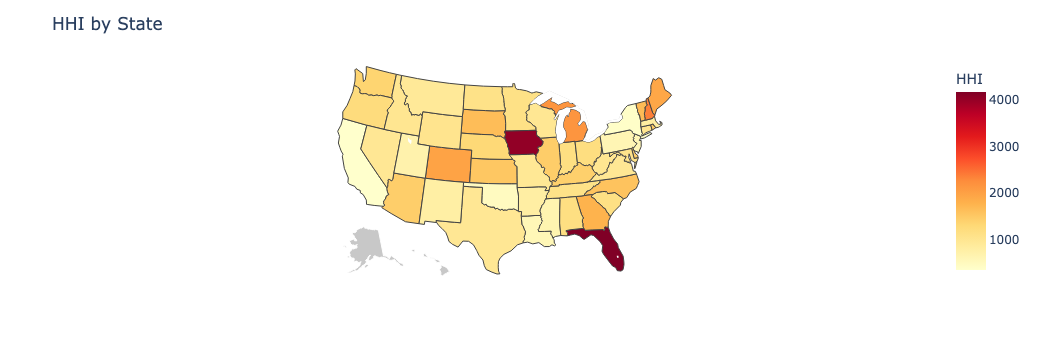

In [55]:
#Generates Chloropleth Map of US based on State Boundaries for HHI Index
import plotly.express as px

fig = px.choropleth(
    hhi_df_2022,
    locations='STATE',
    locationmode='USA-states',
    color='HHI',
    color_continuous_scale='YlOrRd',
    range_color=(hhi_df_2022['HHI'].min(), hhi_df_2022['HHI'].max()),
    scope='usa',
    labels={'STATE': 'State', 'HHI': 'HHI'}
)

fig.update_layout(
    title_text='HHI by State',
    geo=dict(
        showcoastlines=True,
        coastlinecolor='rgb(100,100,100)',
        showland=True,
        landcolor='rgb(200,200,200)',
        showocean=True,
        oceancolor='rgb(247,247,247)',
        showlakes=True,
        lakecolor='rgb(255,255,255)',
        projection_type='albers usa'
    )
)

fig.update_traces(
    hovertemplate='<b>%{location}</b><br>HHI: %{z}<br>Market Concentration: %{customdata}',
    customdata=hhi_df_2022['MARKET CONCENTRATION']
)

fig.show()


# HHI (COUNTY CODES)

In [56]:
def calculate_state_hhi(df, state):
    """
    Calculates the HHI on the state level based on county code
    """
    df_state = df.loc[df["STATE"] == state]
    state_counties = df_state["COUNTY CODE"].unique().tolist()
    hhi_values_state = []

    for county in state_counties:
        df_county = df_state.loc[df_state["COUNTY CODE"] == county]
        df_county = process_dataframe(df_county)
        market_share_county = calculate_market_share(df_county)
        hhi_value_county = hhi(market_share_county["PERCENT"])
        market_concentration_county = categorize_market_concentration(hhi_value_county)
        hhi_values_state.append((county, hhi_value_county, market_concentration_county))

    state_hhi_df = pd.DataFrame(hhi_values_state, columns=["COUNTY CODE", "HHI", "MARKET CONCENTRATION"])
    state_hhi_df["STATE"] = state

    return state_hhi_df


county_hhi = pd.DataFrame(columns=["STATE", "COUNTY CODE", "HHI", "MARKET CONCENTRATION"]) 

for state in states:
    df_state = supermarkets.loc[supermarkets["STATE"] == state]
    county_hhi = calculate_state_hhi(df_state, state)
    county_hhi = pd.concat([county_hhi, state_hhi_nw], ignore_index=True)


In [57]:
county_hhi.head()

,COUNTY CODE,HHI,MARKET CONCENTRATION,STATE
0,31.0,2890.990604,HIGHLY CONCENTRATED,ME
1,5.0,2047.964112,MODERATELY CONCENTRATED,ME
2,17.0,4229.416389,HIGHLY CONCENTRATED,ME
3,23.0,4109.130910,HIGHLY CONCENTRATED,ME
4,19.0,4180.225642,HIGHLY CONCENTRATED,ME
